## DAAA/2B/02, DOAA

## Name: Low Zan Wei Marcus

## Adm Number: 2309264

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from keras import Model
from keras.layers import Dense, Conv2D, Reshape, BatchNormalization, Activation, Input, LeakyReLU, Dropout, Flatten, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize
from scipy.linalg import sqrtm
import keras
import os

## Read file

In [2]:
df = pd.read_csv("../CA2_Part_A/Dataset/emnist-letters-train.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Processing

### Extract X, y

In [3]:
# Extracting features and labels
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

# Normalize the images
X = X / 127.5 - 1

# Reshape the images to the appropriate dimensions
X = X.reshape(-1, 28, 28, 1)


### Remove empty class

In [4]:
# Filter out class -1
valid_classes = np.unique(y)
valid_classes = valid_classes[valid_classes != -1]

# Filter images and labels based on valid classes
valid_indices = np.isin(y, valid_classes)
X = X[valid_indices]
y = y[valid_indices]

# Create a mapping from old class indices to new indices starting from 0
class_to_new_index = {cls: idx for idx, cls in enumerate(valid_classes)}
y = np.array([class_to_new_index[cls] for cls in y])

print("Minimum class value:", y.min())
print("Maximum class value:", y.max())

Minimum class value: 0
Maximum class value: 25


### Map Integer Classes to Alphabet

In [5]:
# Create a mapping from new indices to alphabetic labels
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
class_mapping = {idx: letter for idx, letter in enumerate(alphabet[:len(valid_classes)])}

### Apply Rotation

In [6]:
for i in range(len(X)):# Some funky rotations code
    for j in range(len(X[i])):
        X[i][j] = np.flip(X[i][j])
    X[i] = np.rot90(X[i], k=1)

In [7]:
# Convert labels to integers
y = np.asarray(y, dtype=int)
num_classes = 26
y = keras.utils.to_categorical(y, num_classes)  # Convert to one-hot encoding


In [8]:
print(X.shape)
print(y.shape)

(88800, 28, 28, 1)
(88800, 26)


## Model Architecture

In [9]:
# Load the InceptionV3 model for FID calculation
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(84, 84, 3))

class CGAN:
    def __init__(self, img_rows, img_cols, channels, num_classes, z, discriminator_steps=2, generator_steps=3):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.num_classes = num_classes
        self.latent_dim = z
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.img_shape = (img_rows, img_cols, channels)
        # self.build_and_compile_models()
    
    def build_generator(self):
        """Build a Generator Model"""
        inputs = Input(shape=(self.latent_dim,))
        labels = Input(shape=(self.num_classes,))
        image_size = self.img_rows
        
        # Concatenate noise and label
        x = concatenate([inputs, labels], axis=1)
        x = Dense(image_size // 4 * image_size // 4 * 128)(x)
        x = Reshape((image_size // 4, image_size // 4, 128))(x)

        for filters in [128, 64, 32, self.channels]:
            strides = 2 if filters > 32 else 1
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2DTranspose(filters=filters, kernel_size=5, strides=strides, padding='same')(x)

        x = Activation('tanh')(x)
        generator = Model([inputs, labels], x, name='generator')
        generator.summary()
        return generator
    
    def build_discriminator(self):
        """Build a Discriminator Model"""
        inputs = Input(shape=self.img_shape)
        labels = Input(shape=(self.num_classes,))
        image_size = self.img_rows
        
        # Embed the labels
        y = Dense(image_size * image_size)(labels)  # Ensure this matches the flattened size
        y = Reshape((image_size, image_size, 1))(y)  # Correct shape
        
        x = concatenate([inputs, y])

        for filters in [32, 64, 128, 256]:
            strides = 2 if filters != 256 else 1
            x = Conv2D(filters=filters, kernel_size=5, strides=strides, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = Dropout(0.4)(x)

        x = Flatten()(x)
        x = Dense(1)(x)
        x = Activation('sigmoid')(x)
        discriminator = Model([inputs, labels], x, name='discriminator')
        discriminator.summary()
        return discriminator


    # def build_and_compile_models(self):
    #     """Build and compile Generator and Discriminator models"""
    #     # Build discriminator model
    #     self.discriminator = self.build_discriminator()
    #     optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    #     self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    #     # Build generator model
    #     self.generator = self.build_generator()

    #     # Build adversarial model
    #     self.discriminator.trainable = False
    #     noise = Input(shape=(self.latent_dim,))
    #     label = Input(shape=(self.num_classes,))
    #     img = self.generator([noise, label])
    #     validity = self.discriminator([img, label])
    #     self.combined = Model([noise, label], validity)
    #     self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def load_weights(self, filepath_prefix):
        weights_dir = r'C:\Singapore Poly\DAAA2024S2\DOAA_DAAA\CA2_DOAA\ca2-daaa2b02-2309264-marcuslow\CA2_Part_A\gan_trained_weights'
        
        # Build the generator model if it's not already built
        if not hasattr(self, 'generator'):
            self.generator = self.build_generator()

        # Load weights into the generator model
        generator_weights_path = os.path.join(weights_dir, f'{filepath_prefix}_generator.h5')
        
        if os.path.exists(generator_weights_path):
            self.generator.load_weights(generator_weights_path)
            print(f"Generator weights loaded from {generator_weights_path}")
        else:
            print(f"Error: File not found at {generator_weights_path}")

def calculate_fid(X_train, generator, num_classes, num_images_per_class=500):
    real_images = X_train[:num_classes * num_images_per_class]
    # Initialize an empty list to collect generated images
    all_generated_images = []

    for class_idx in range(num_classes):
        # Print progress
        print(f'Generating images for class {class_idx+1}/{num_classes}')

        # Generate noise and one-hot labels for the current class
        noise = np.random.normal(0, 1, (num_images_per_class, 100))  # Noise for each sample
        one_hot = np.zeros((num_images_per_class, num_classes))  # Initialize one-hot labels array
        one_hot[:, class_idx] = 1  # Set the relevant class index to 1

        # Generate images for the current class
        generated_images = generator.predict([noise, one_hot])

        # Append the generated images to the list
        all_generated_images.append(generated_images)

    # Convert the list of arrays to a single NumPy array
    all_generated_images = np.vstack(all_generated_images)

    # Preprocess images
    real_images_resized = np.array([resize(image, (84, 84, 3)) for image in real_images])
    generated_images_resized = np.array([resize(image, (84, 84, 3)) for image in all_generated_images])

    # Calculate activations
    act1 = inception_model.predict(real_images_resized)
    act2 = inception_model.predict(generated_images_resized)

    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

### Loading weights

In [10]:
# Initialize the CGAN
cgan = CGAN(img_rows=28, img_cols=28, channels=1, num_classes=26, z=100)


# Load the weights into the generator, discriminator, or combined model
cgan.load_weights('cgan_Epoch_4900')

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 126)          0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 6272)         796544      ['concatenate_2[0][0]']  

## Accuracy 

## FID Score (for generator)

In [11]:
# Extract the generator from the CGAN object
generator = cgan.generator

# Assume `X_train` is your dataset of real images
fid_score = calculate_fid(X_train=X, generator=generator, num_classes=26, num_images_per_class=500)

print(f'FID score: {fid_score}')

Generating images for class 1/26
16/16 [==============================] - 1s 44ms/step
Generating images for class 2/26
16/16 [==============================] - 1s 47ms/step
Generating images for class 3/26
16/16 [==============================] - 1s 54ms/step
Generating images for class 4/26
16/16 [==============================] - 1s 61ms/step
Generating images for class 5/26
16/16 [==============================] - 1s 50ms/step
Generating images for class 6/26
16/16 [==============================] - 1s 55ms/step
Generating images for class 7/26
16/16 [==============================] - 1s 58ms/step
Generating images for class 8/26
16/16 [==============================] - 1s 49ms/step
Generating images for class 9/26
16/16 [==============================] - 1s 50ms/step
Generating images for class 10/26
16/16 [==============================] - 1s 53ms/step
Generating images for class 11/26
16/16 [==============================] - 1s 46ms/step
Generating images for class 12/26
16/16 [

#### FID score for generator is 38.691

## Function to Generate and save image grid

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def generate_image_grid(cgan_model, rows, cols, latent_dim, num_classes, save_path="cgan_collage_image/260_images_collage.png"):
    """
    Generates a grid of images using the CGAN model, displays it with column labels, and saves it as a PNG file.
    
    Parameters:
        cgan_model (CGAN): The CGAN model instance.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
        latent_dim (int): Dimensionality of the latent vector.
        num_classes (int): Number of classes for one-hot encoding.
        save_path (str): Path to save the generated image grid.
    """
    
    # Generate noise and one-hot labels
    noise = np.random.normal(0, 1, (rows * cols, latent_dim))
    labels = np.zeros((rows * cols, num_classes))
    
    for i in range(rows):
        for j in range(cols):
            class_idx = j % num_classes  # Cycle through class indices
            labels[i * cols + j, class_idx] = 1  # One-hot encoding for each class
    
    print(noise.shape)
    print(labels.shape)

    # Generate images
    gen_imgs = cgan_model.generator.predict([noise, labels])
    
    # Rescale images to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Create a grid of images
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    
# Handle the case for a 1x1 grid (single image)
    if rows == 1 and cols == 1:
        axs.imshow(gen_imgs[0, :, :, 0], cmap='gray')
        axs.axis('off')  # Hide axis for the single image
    else:
        # Handle larger grids
        for i in range(rows):
            for j in range(cols):
                axs[i, j].imshow(gen_imgs[i * cols + j, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
    
    # Add labels at the top of each column (only for multi-column grids)
    if rows > 1 or cols > 1:
        alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        for j in range(cols):
            axs[0, j].set_title(alphabet[j % len(alphabet)], fontsize=30)  # Add labels at the top

    # Adjust layout to fit labels and images tightly
    plt.tight_layout()
    
    # Save the grid as a PNG file
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

    print(f"Image grid saved as {save_path}")


### Generate Images

(260, 100)
(260, 26)
9/9 [==============================] - 0s 44ms/step


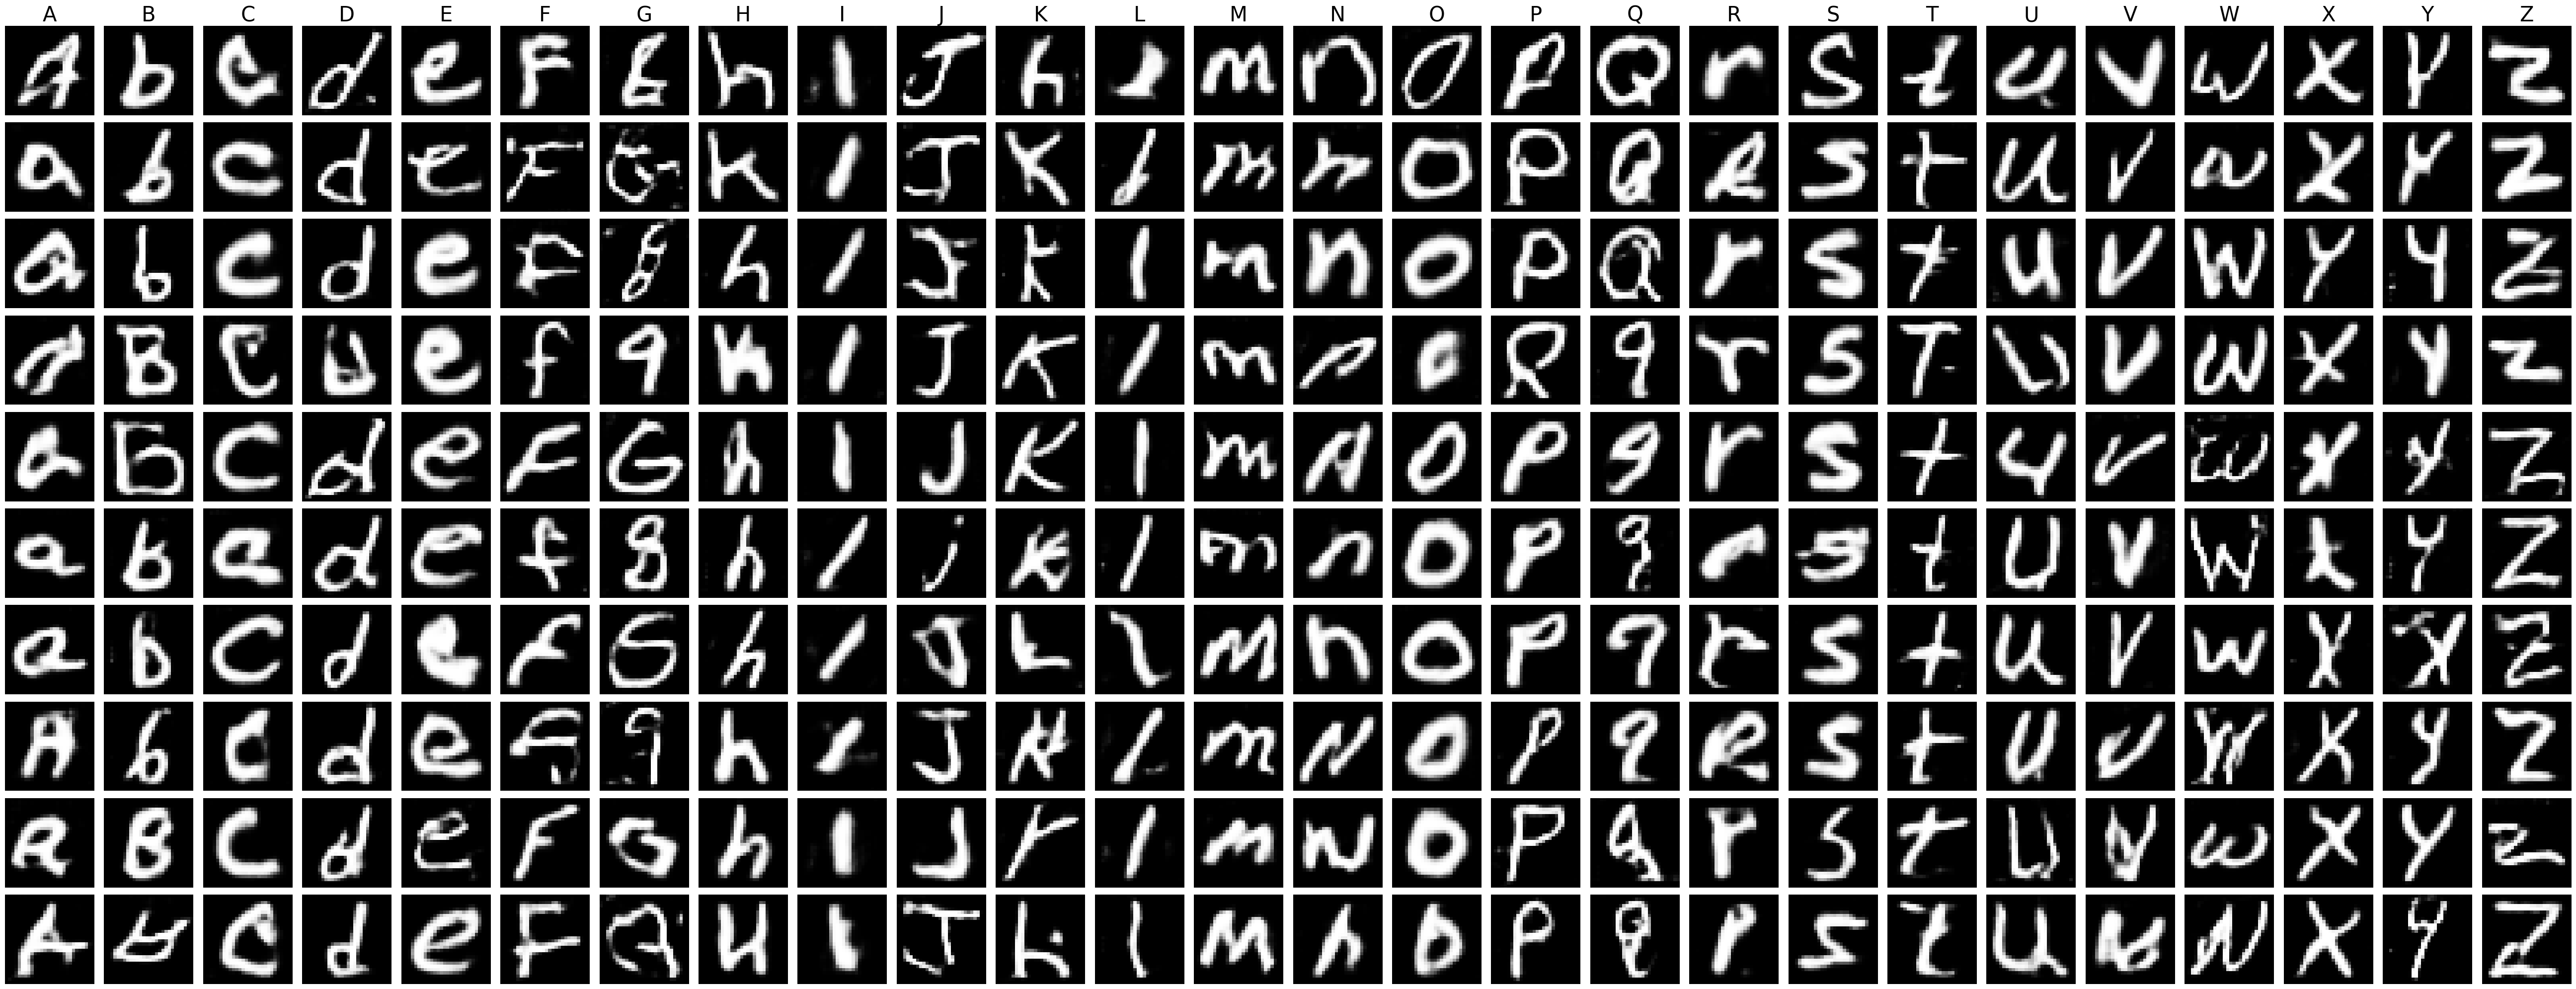

Image grid saved as cgan_collage_image/260_images_collage.png


In [13]:
# Generate and display the image grid
generate_image_grid(cgan, rows=10, cols=26, latent_dim=100, num_classes=26)

## Deployment to render process (show render link)

## Step 1: Export the Model for Tensorflow Serving

- Load the model weights from the DELE CA2.
- Save the generator model weights only.
- Export the model for tf serving container.

### Save Generator

In [14]:
#save model
ts = int(time.time())

export_path_generator = f"./models/cgan/{ts}/"
tf.saved_model.save(cgan.generator, export_path_generator)
print(f"Generator model saved to: {export_path_generator}")

INFO:tensorflow:Assets written to: ./models/cgan/1739588243/assets


INFO:tensorflow:Assets written to: ./models/cgan/1739588243/assets


Generator model saved to: ./models/cgan/1739588243/


In [15]:
# Load the saved model
loaded_model_gen = tf.saved_model.load(export_path_generator)

# Check the model signature to confirm it was loaded correctly
print(loaded_model_gen.signatures)

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, input_3, input_2) at 0x22760FA7F70>})


## Step 2: Create Tensorflow Serving container by mounting the exported model

2.1 (Pull the Tensorflow Serving Docker image): 
- docker pull tensorflow/serving

2.2 (Run the TensorFlow Serving container, mounting the exported generator/discriminator model):
#### Generator mounted inside container (CGAN and DCGAN)
- docker run --name=tf_combined_gen -p 8501:8501 -v "C:/Singapore Poly/DAAA2024S2/DOAA_DAAA/CA2_DOAA/ca2-daaa2b02-2309264-marcuslow/CA2_Part_A/models/cgan:/models/cgan" -v "C:/Singapore Poly/DAAA2024S2/DOAA_DAAA/CA2_DOAA/ca2-daaa2b02-2309264-marcuslow/CA2_Part_A/models/dcgan:/models/dcgan" -v "C:/Singapore Poly/DAAA2024S2/DOAA_DAAA/CA2_DOAA/ca2-daaa2b02-2309264-marcuslow/CA2_Part_A/models/models.config:/models/models.config" -t tensorflow/serving

You should see something like this:
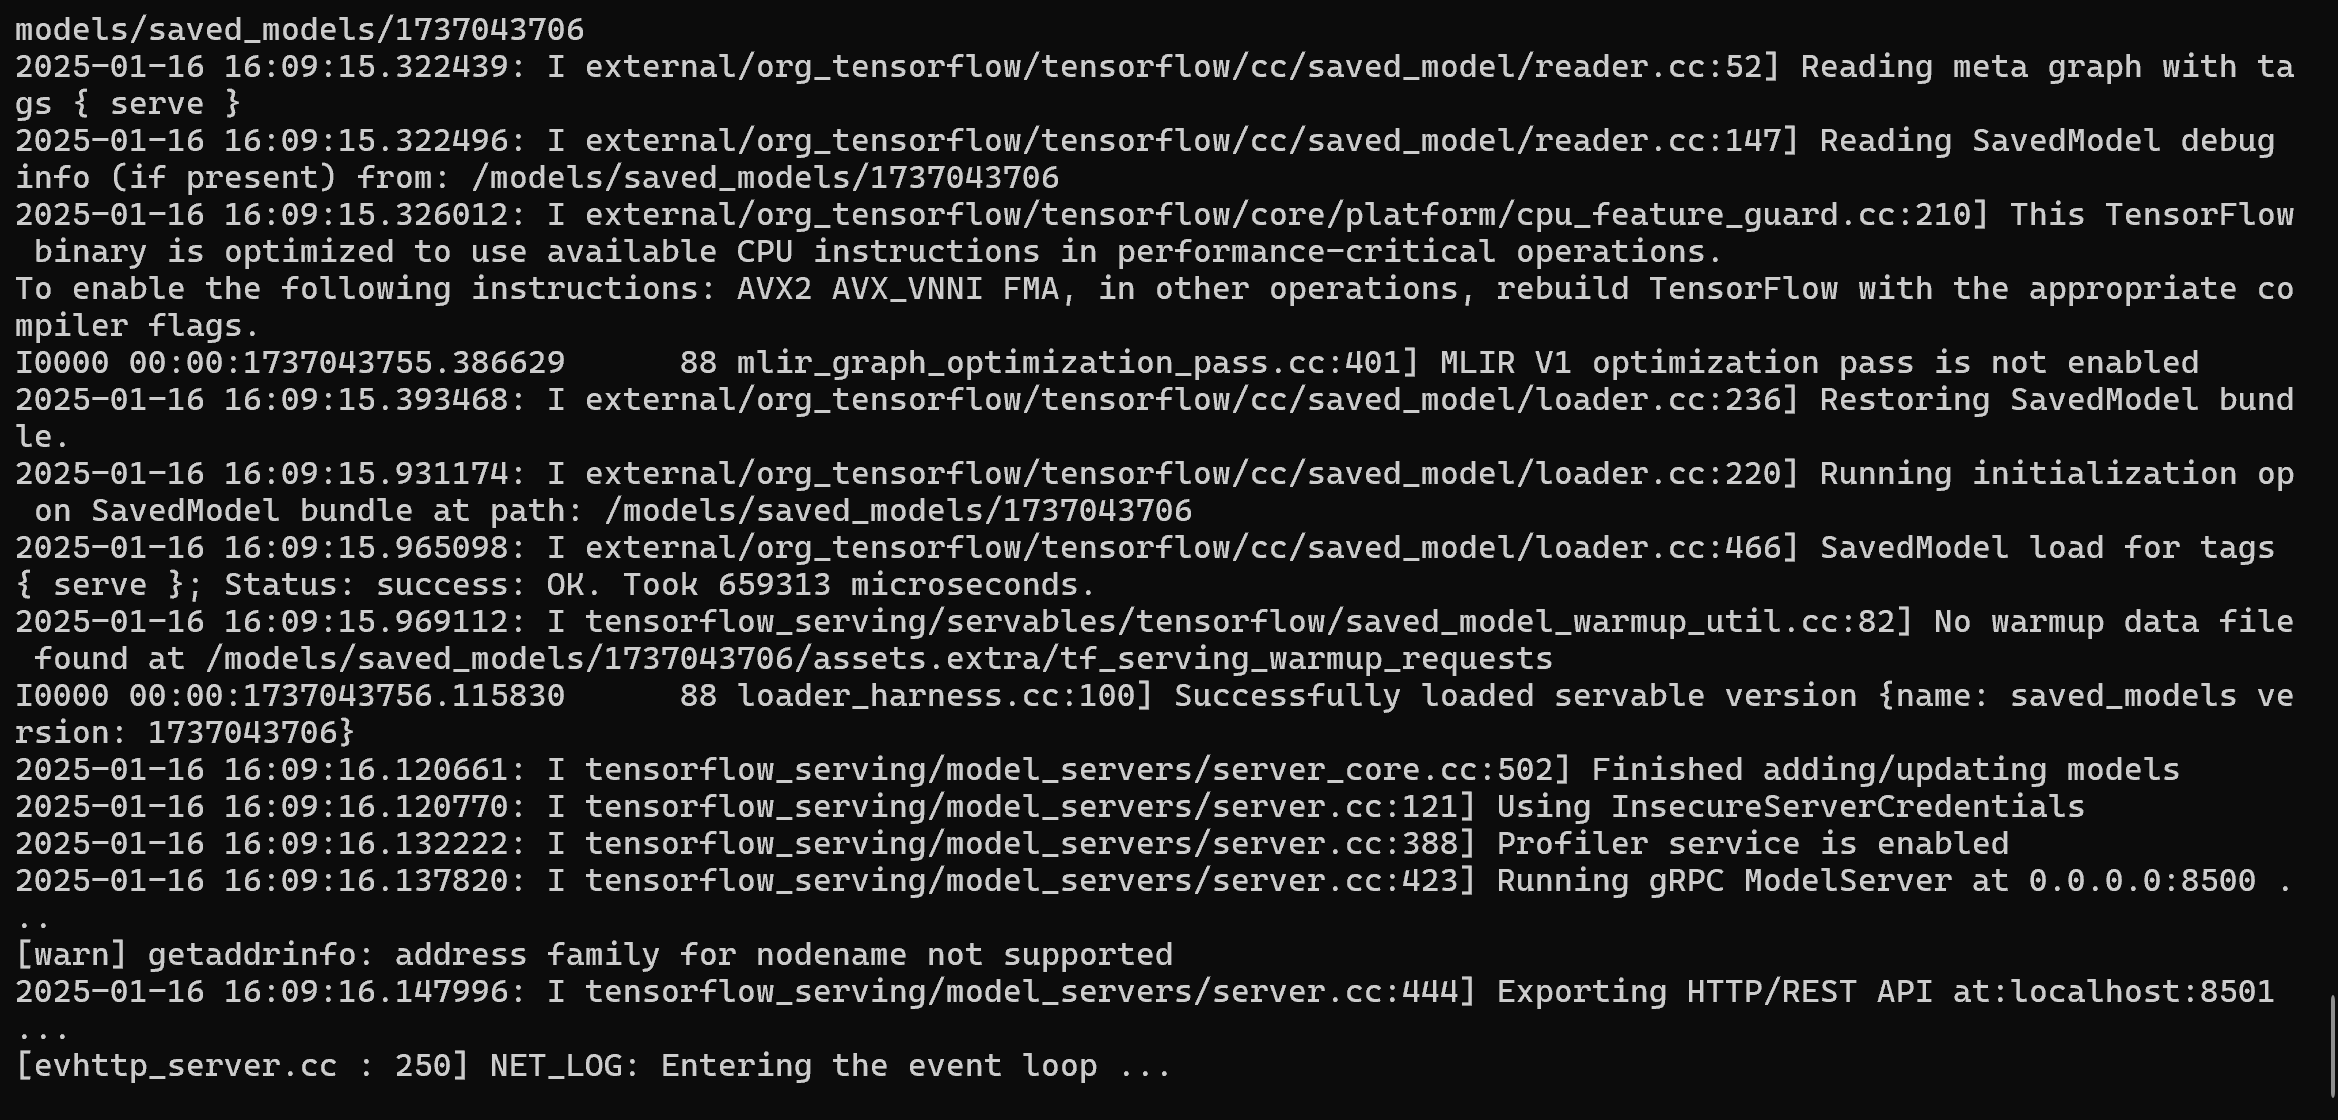

## Step 3: Using Render

- First create Dockerfile.gen to deploy the model on Render using Docker
- Dockerfile will specify the environment, how to copy your model into the container, and how to run TensorFlow Serving.
- Once the image is built, you can test it locally and push it to a container registry for deployment on Render.
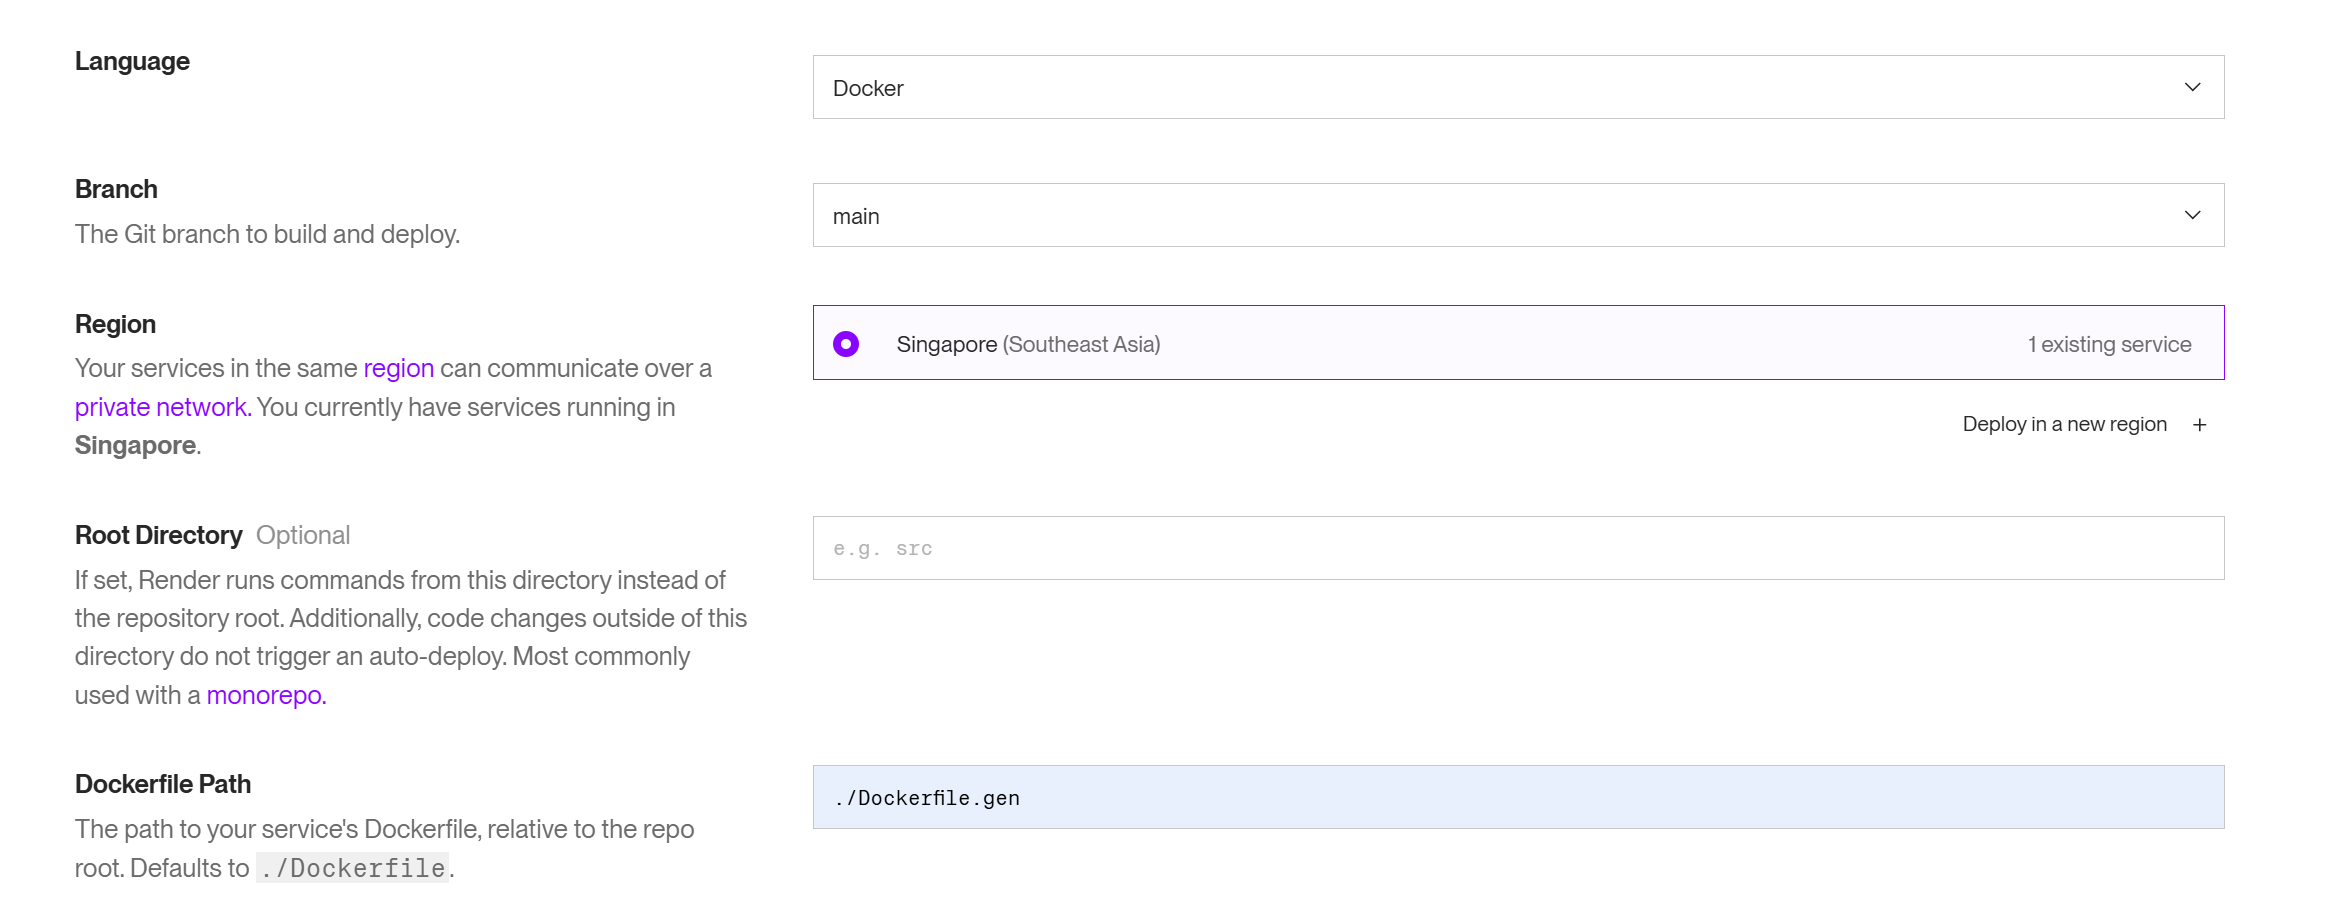

To access the webpage on Render:

##### Generator
- https://gan-gen-ca2.onrender.com/v1/models/generator